In [5]:
using Pkg
Pkg.activate(".")

using GLMakie, NPZ, FFTW, DeconvMultiStep, FITSIO, FourierTools

  Activating project at `~/DeconvMultiStep.jl/notebooks`


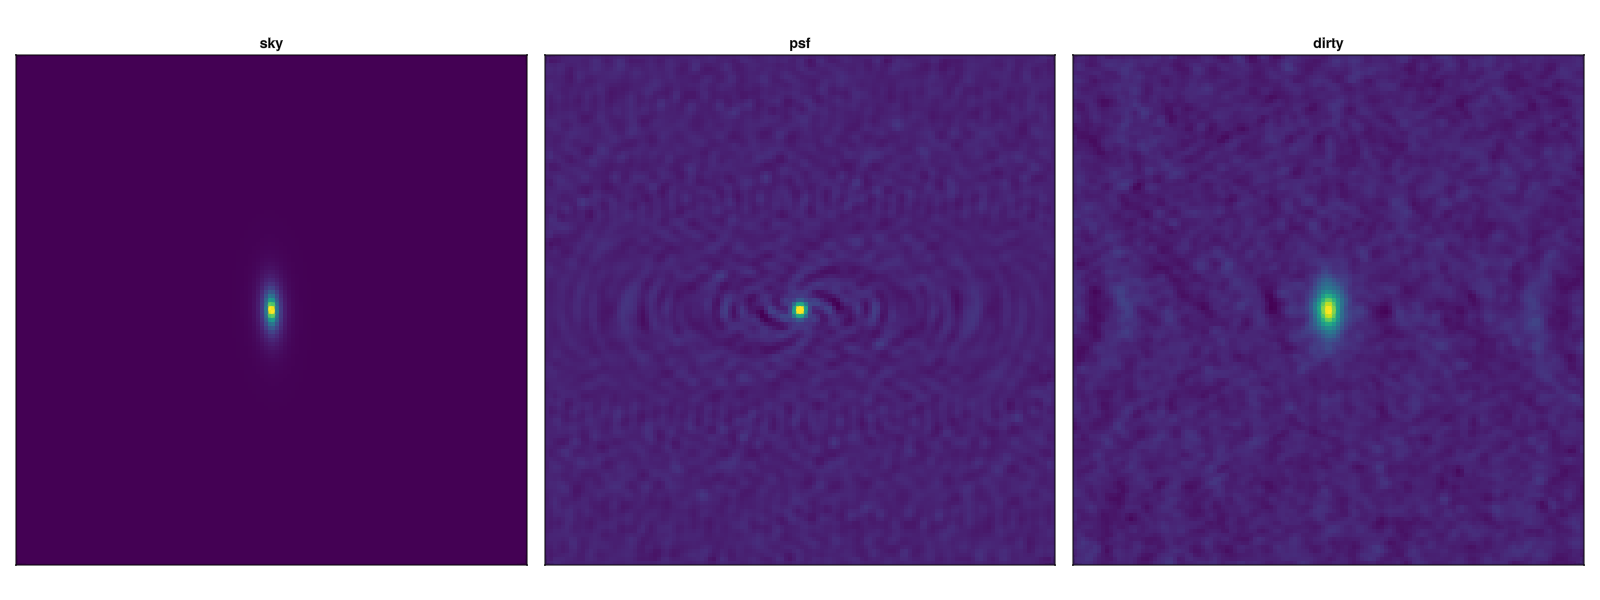

In [6]:
num_sky = 1
psf = npzread("psf.npy")
sky = npzread("true.npy")[num_sky,:,:]
dirty_low = npzread("dirty_low_noise.npy")[num_sky,:,:]
dirty_high = npzread("dirty_proper_noise.npy")[num_sky,:,:]

n = size(psf)[1]
truncated_psf = copy(psf[2:end, 2:end])
trunc_padded = vcat(zeros(1,n), hcat(zeros(n-1,1), truncated_psf))
psf = shift(trunc_padded, (-0.5, -0.5))

fig = Figure(; size = (1600, 600))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="psf", aspect=DataAspect())
ax3 = Axis(fig[1, 3], title="dirty", aspect=DataAspect())
heatmap!(ax1, sky)
heatmap!(ax2, psf)
heatmap!(ax3, dirty_low)

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
fig

Wiener filter for $i=h\ast x+e$ is $w$ such that its Fourier transform equals
$$
W_k = \frac{H_k^\ast}{|H_k|^2 + \frac{S^e_k}{S^x_k}}
$$

- $S^x_k$ and $S^e_k$ PSD of $x$ and $e$ at frequency $k$
- $H_k$ Fourier transform of $h$ at frequency $k$

We consider:
- First $S^e_k/S^x_k = \alpha$ and optimize  $\alpha$ to maximize SNR
- Second $S^e_k/S^x_k = \alpha S^e_k$ and optimize  $\alpha$ to maximize SNR

-> snr with cov: snr=3.317816195158387, α = 9.539370078740157


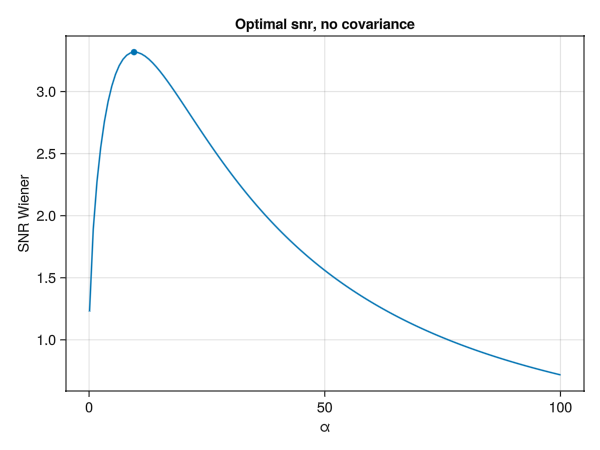

In [7]:
# optimize α no noise covariance

function wiener(dirty, psf, α)
    fpsf = fft(ifftshift(psf))
    isa(α, Number) && (α = α*ones(size(psf)))
    W = conj(fpsf)./(abs2.(fpsf) + α)
    real.(ifft(W.*fft(dirty)))
end

function wiener2(dirty, psf, si, sigma2)
    fpsf = fft(ifftshift(psf))
    isa(si, Number) && (si = si*ones(size(psf)))
    W = si./(si .* fpsf + sigma2*ones(size(psf)))
    real.(ifft(W.*fft(dirty)))
end

function crop_img(x, size_mask) 
    (l,n) = size(x)
    x[size_mask+1:l-size_mask, size_mask+1:n-size_mask]
end

comp_snr(x̂, x, size_mask) =  sum(crop_img(x̂, size_mask).^2)/sum(crop_img(x - x̂, size_mask).^2)

# optimize snr no cov

size_mask = 30
#mask = comp_mask(sky, 30) 
α_pl = LinRange(1e-1, 1e2, 128)
snrs = Float64[]
for α in α_pl
    deconv_nocov = wiener(dirty_low, psf, α)
    push!(snrs, comp_snr(deconv_nocov, sky, size_mask)) 
end

snr_nocov, ind = findmax(snrs)
α_nocov = α_pl[ind]

println("-> snr with cov: snr=$snr_nocov, α = $α_nocov")


fig = Figure()
ax1 = Axis(fig[1, 1], title  = "Optimal snr, no covariance", ylabel = "SNR Wiener", xlabel="α")
lines!(α_pl, snrs)
scatter!([α_nocov], [snr_nocov])
fig

-> snr with cov: snr=2.4637936859022265, α = 11.101574803149607


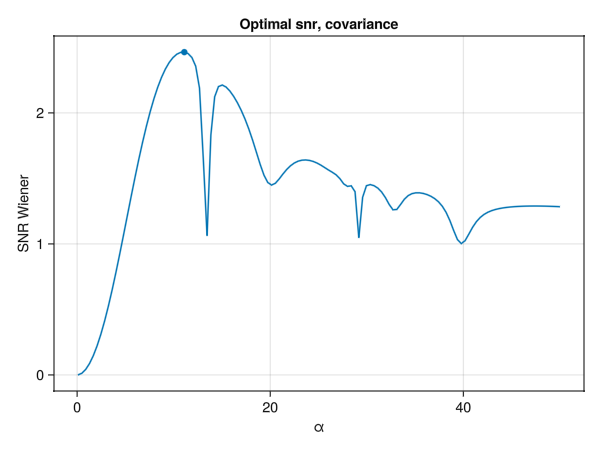

In [8]:
# optimize snr with noise covariance

fpsf = abs.(fft(ifftshift(psf)))
#mask = comp_mask(sky, 30) 
α_pl = LinRange(1e-1, 5e1, 128)
snrs = Float64[]

for α in α_pl
    #deconv_cov = wiener(dirty_low, psf, α*fpsf)
    deconv_cov = wiener2(dirty_low, psf, α, 50)
    push!(snrs, comp_snr(deconv_cov, sky, size_mask)) 
end

snr_cov, ind = findmax(snrs)
α_cov = α_pl[ind]

println("-> snr with cov: snr=$snr_cov, α = $α_cov")

fig = Figure()
ax1 = Axis(fig[1, 1], title  = "Optimal snr, covariance", ylabel = "SNR Wiener", xlabel="α")
lines!(α_pl, snrs)
scatter!([α_cov], [snr_cov])
fig

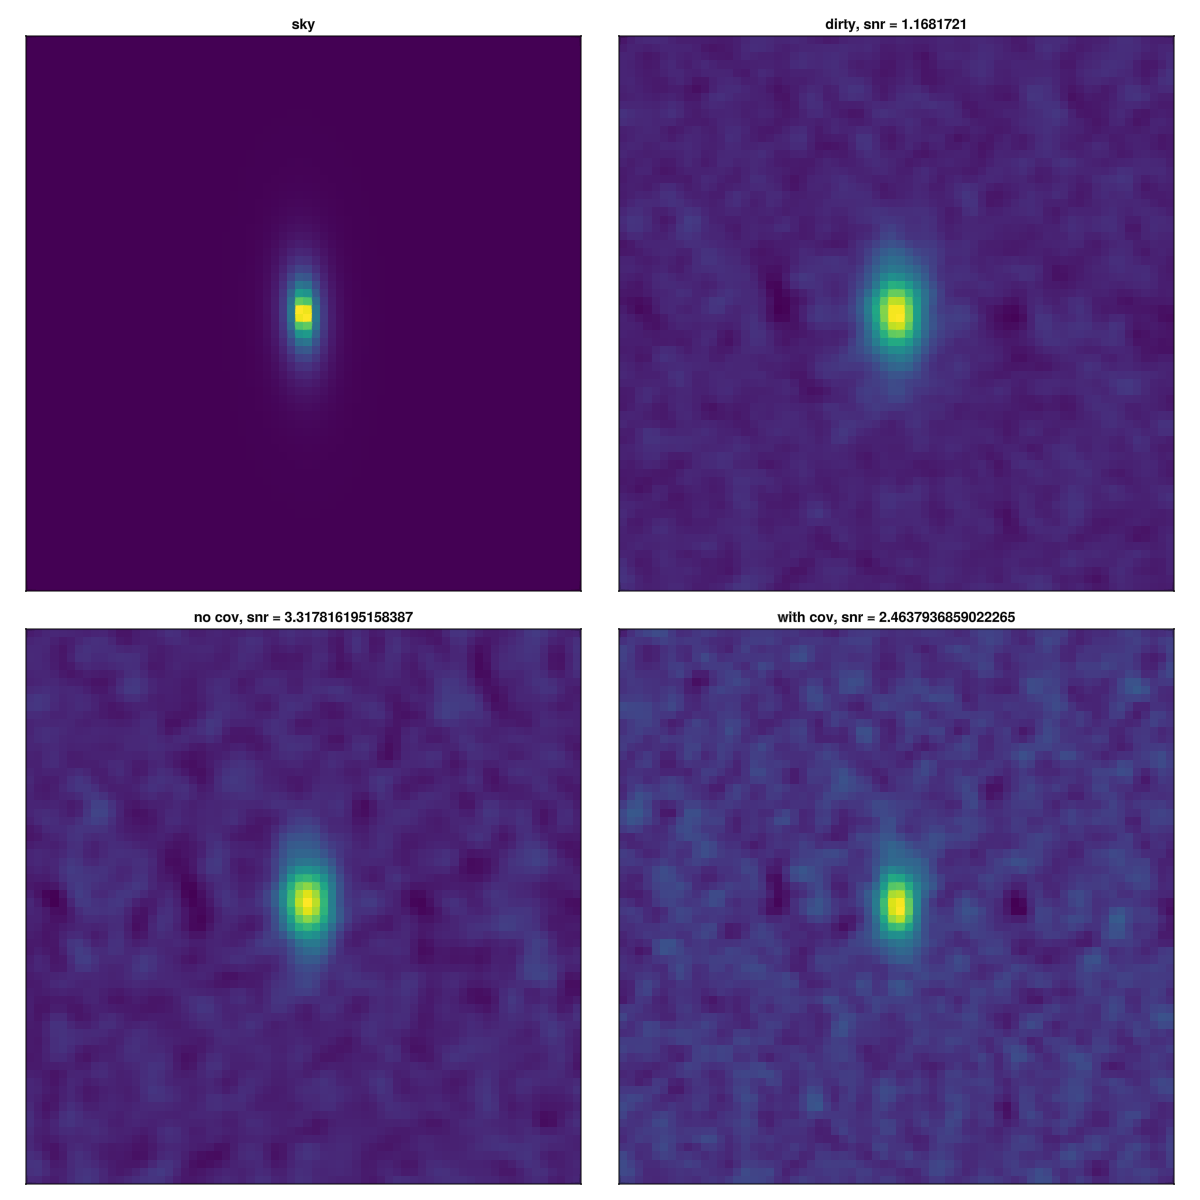

In [9]:
deconv_nocov = wiener(dirty_low, psf, α_nocov)
#deconv_cov = wiener(dirty_low, psf, α_cov*fpsf)
deconv_cov = wiener2(dirty_low, psf, α_cov, 50)
snr_dirty = comp_snr(dirty_low, sky, size_mask)

fig = Figure(; size = (1200, 1200))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="dirty, snr = $snr_dirty", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="no cov, snr = $snr_nocov", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="with cov, snr = $snr_cov", aspect=DataAspect())
heatmap!(ax1, crop_img(sky, size_mask))
heatmap!(ax2, crop_img(dirty_low, size_mask))
heatmap!(ax3, crop_img(deconv_nocov, size_mask))
heatmap!(ax4, crop_img(deconv_cov, size_mask))

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
hidedecorations!(ax4)
fig

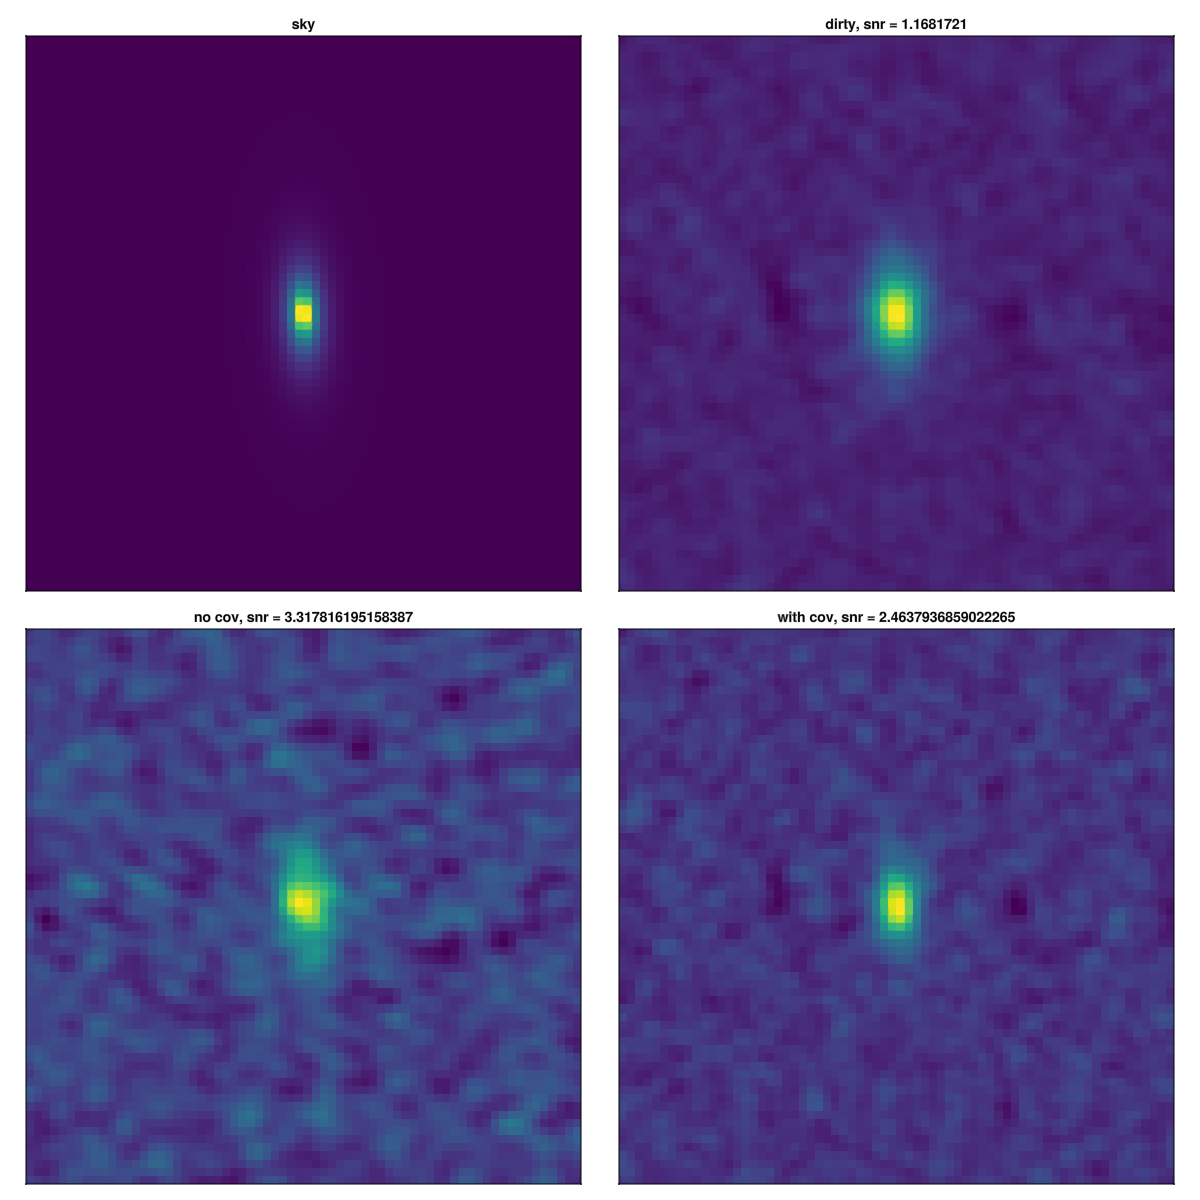

In [10]:
deconv_nocov = wiener(dirty_high, psf, 80)
#deconv_cov = wiener(dirty_low, psf, α_cov*fpsf)
deconv_cov = wiener2(dirty_low, psf, α_cov, 50)
snr_dirty = comp_snr(dirty_low, sky, size_mask)

fig = Figure(; size = (1200, 1200))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="dirty, snr = $snr_dirty", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="no cov, snr = $snr_nocov", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="with cov, snr = $snr_cov", aspect=DataAspect())

heatmap!(ax1, crop_img(sky, size_mask))
heatmap!(ax2, crop_img(dirty_low, size_mask))
heatmap!(ax3, crop_img(deconv_nocov, size_mask))
heatmap!(ax4, crop_img(deconv_cov, size_mask))

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
hidedecorations!(ax4)
fig

## For FISTA

In [11]:
using DeconvMultiStep
using LinearAlgebra

function imfilter(img::Matrix{T}, psf::Matrix{T}) where {T<:Real}
    @assert size(img) == size(psf) "Image and psf must have the same size"
    real(ifft(fft(img).*fft(ifftshift(psf))))
end

psf = reshape(psf, (128, 128))
sky = reshape(sky, (128, 128))
dirty_low = reshape(dirty_low, (128, 128))
dirty_high = reshape(dirty_high, (128, 128));

### First without variance taken into account

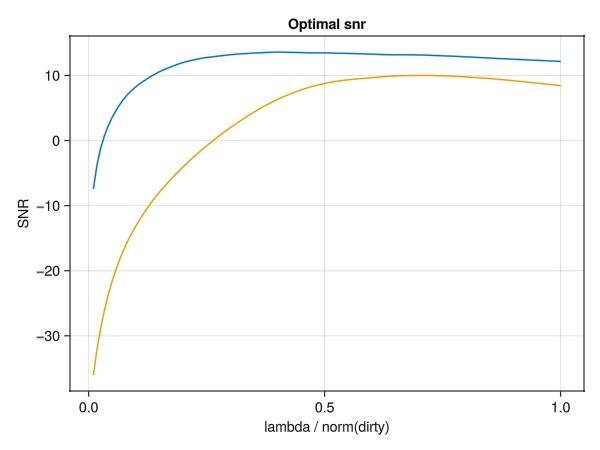

In [13]:
lambdas = LinRange(1e-2, 1, 128)

snrs_low = Float64[]
snrs_high = Float64[]
for lambda in lambdas
    deconv, dist, mse, costs = fista(Float64.(psf), Float64.(dirty_low), lambda * norm(dirty_low), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_low, snr) 
end
for lambda in lambdas
    deconv, dist, mse, costs = fista(Float64.(psf), Float64.(dirty_high), lambda * norm(dirty_high), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_high, snr) 
end

fig = Figure()
ax1 = Axis(fig[1, 1], title  = "Optimal snr", ylabel = "SNR", xlabel="lambda / norm(dirty)")
lines!(lambdas, snrs_low)
lines!(lambdas, snrs_high)
#scatter!([α_cov], [snr_cov])
fig

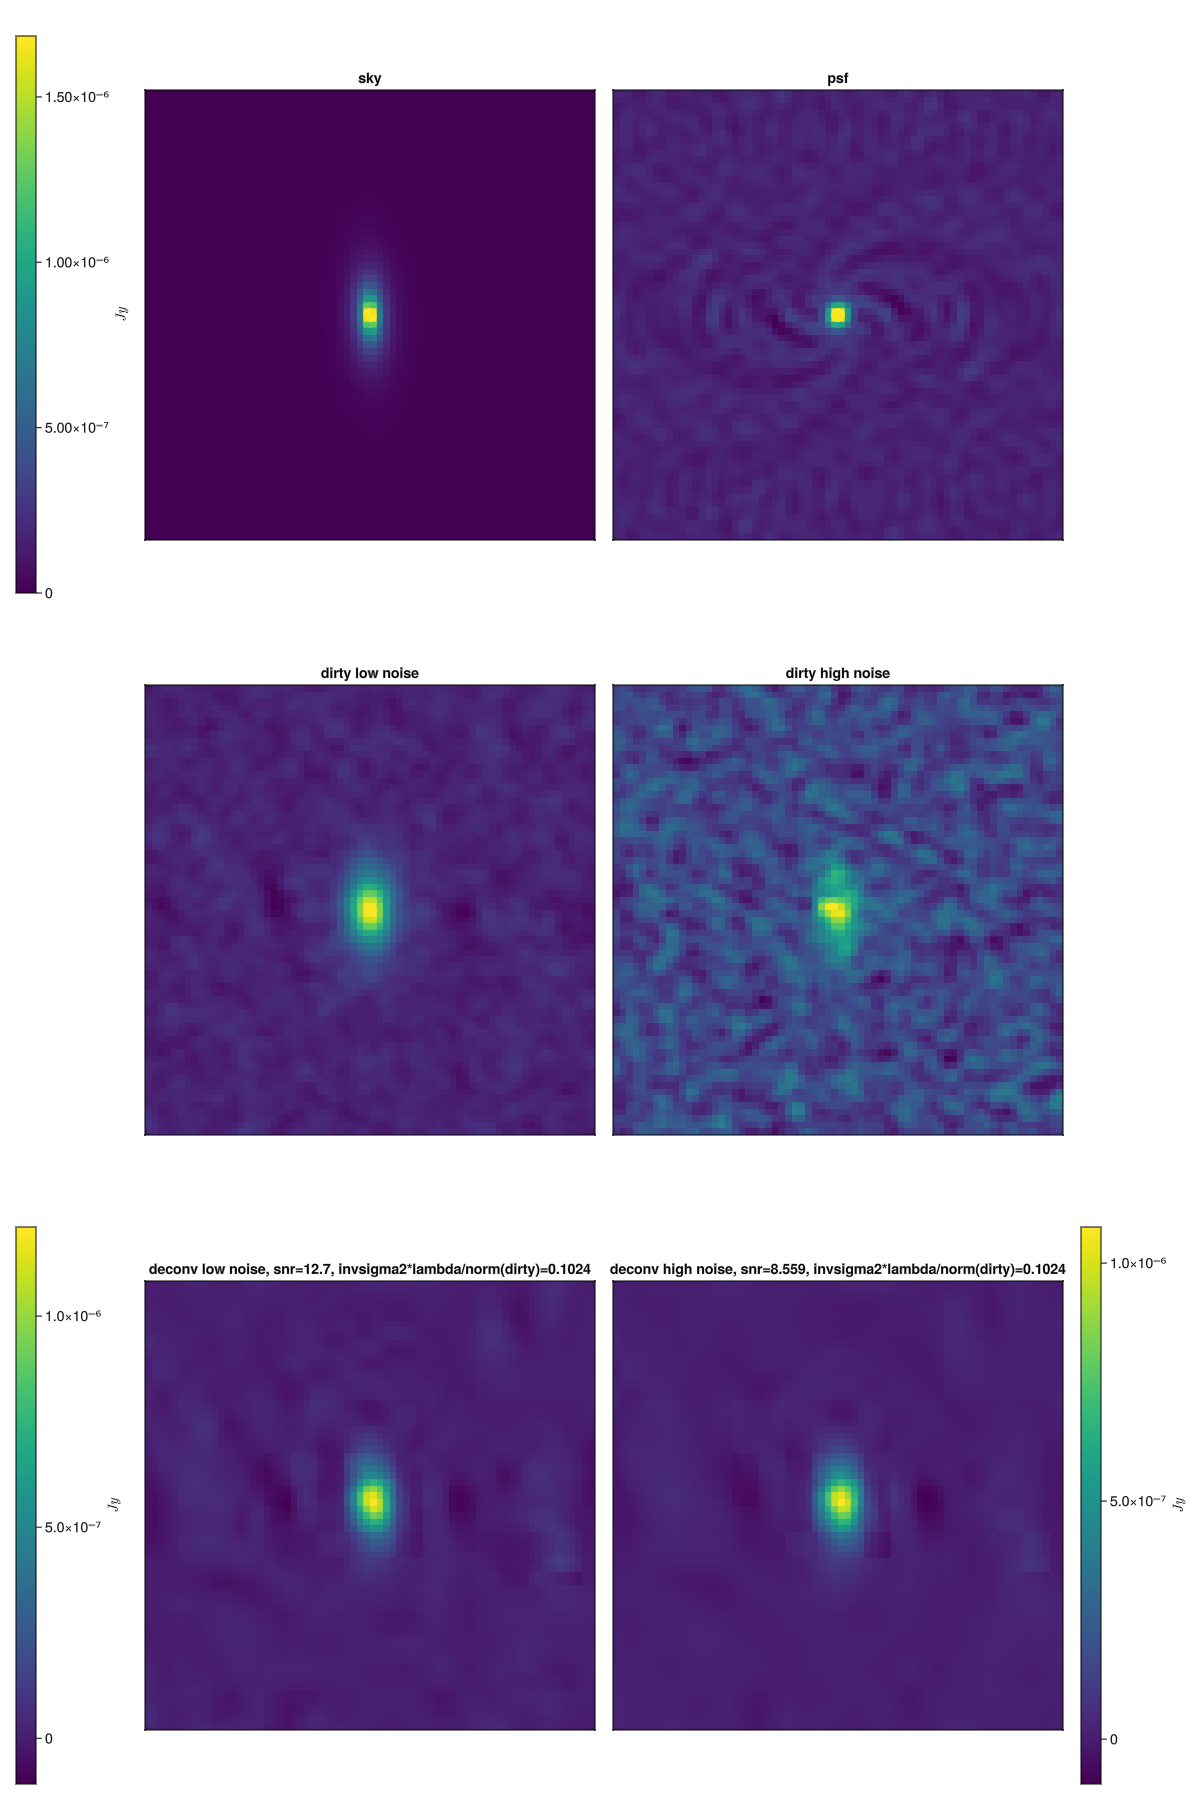

In [33]:
snr_low, ind_low = findmax(snrs_low)
snr_high, ind_high = findmax(snrs_high)

low_lambda = lambdas[ind_low] * norm(dirty_low)
high_lambda = lambdas[ind_high] * norm(dirty_high)

deconv_low, dist, mse, costs = fista(Float64.(psf), Float64.(dirty_low), low_lambda, 50; sky=Float64.(sky))
deconv_high, dist, mse, costs = fista(Float64.(psf), Float64.(dirty_low), high_lambda, 50; sky=Float64.(sky))

fig = Figure(; size = (1200, 1800))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="psf", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="dirty low noise", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="dirty high noise", aspect=DataAspect())

llow = lambdas[ind_low]
lhigh = lambdas[ind_high]

ax5 = Axis(fig[3, 1], title="deconv low noise, snr=$(round(snr_low, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(llow, sigdigits=4))", aspect=DataAspect())
ax6 = Axis(fig[3, 2], title="deconv high noise, snr=$(round(snr_high, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(lhigh, sigdigits=4))", aspect=DataAspect())

hm = heatmap!(ax1, crop_img(sky, size_mask))
Colorbar(fig[1, 0], hm, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
heatmap!(ax2, crop_img(psf, size_mask))
heatmap!(ax3, crop_img(dirty_low, size_mask))
heatmap!(ax4, crop_img(dirty_high, size_mask))
hm2 = heatmap!(ax5, crop_img(deconv_low, size_mask))
Colorbar(fig[3, 0], hm2, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
hm3 = heatmap!(ax6, crop_img(deconv_high, size_mask))
Colorbar(fig[3, 3], hm3, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
hidedecorations!(ax4)
hidedecorations!(ax5)
hidedecorations!(ax6)
hidedecorations!(ax7)
hidedecorations!(ax8)
fig

### Now assuming some i.i.d Gaussian noise in the gridded visibility domain, i.e. $\sigma^2 H$ in the image domain
### With $H = F^\dagger \Delta F$ and $\Sigma = \sigma^2 I$, we have a gradient of $W^\dagger F^\dagger \Delta^\dagger \Delta^\# \Sigma^{-1}(\Delta F W\alpha - F\tilde{\imath})$  where $\dagger$ denotes conjugate transpose and $\#$ denotes pseudo-inverse.

In [53]:
using FFTW

lambdas = LinRange(1e-5, 1, 128)

invsigma2 = 1

fpsf = fft(ifftshift(psf))
fcov = ComplexF64.([abs(x) > 1e-4 ? invsigma2 / x : 0 for x in fpsf])
cov = real.(fftshift(ifft(fcov)));

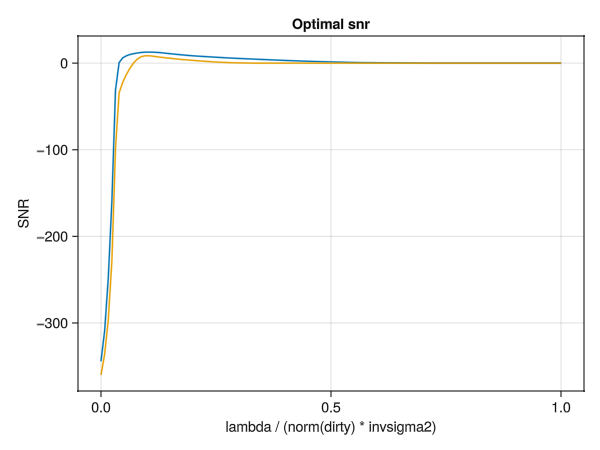

In [19]:
snrs_low = Float64[]
snrs_high = Float64[]
for lambda in lambdas
    deconv, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), invsigma2 * lambda * norm(dirty_low), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_low, snr) 
end
for lambda in lambdas
    deconv, mse = fista_cov(Float64.(psf), Float64.(dirty_high), Float64.(cov), invsigma2 * lambda * norm(dirty_high), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_high, snr) 
end

fig = Figure()
ax1 = Axis(fig[1, 1], title  = "Optimal snr", ylabel = "SNR", xlabel="lambda / (norm(dirty) * invsigma2)")
lines!(lambdas, snrs_low)
lines!(lambdas, snrs_high)
#scatter!([α_cov], [snr_cov])
fig

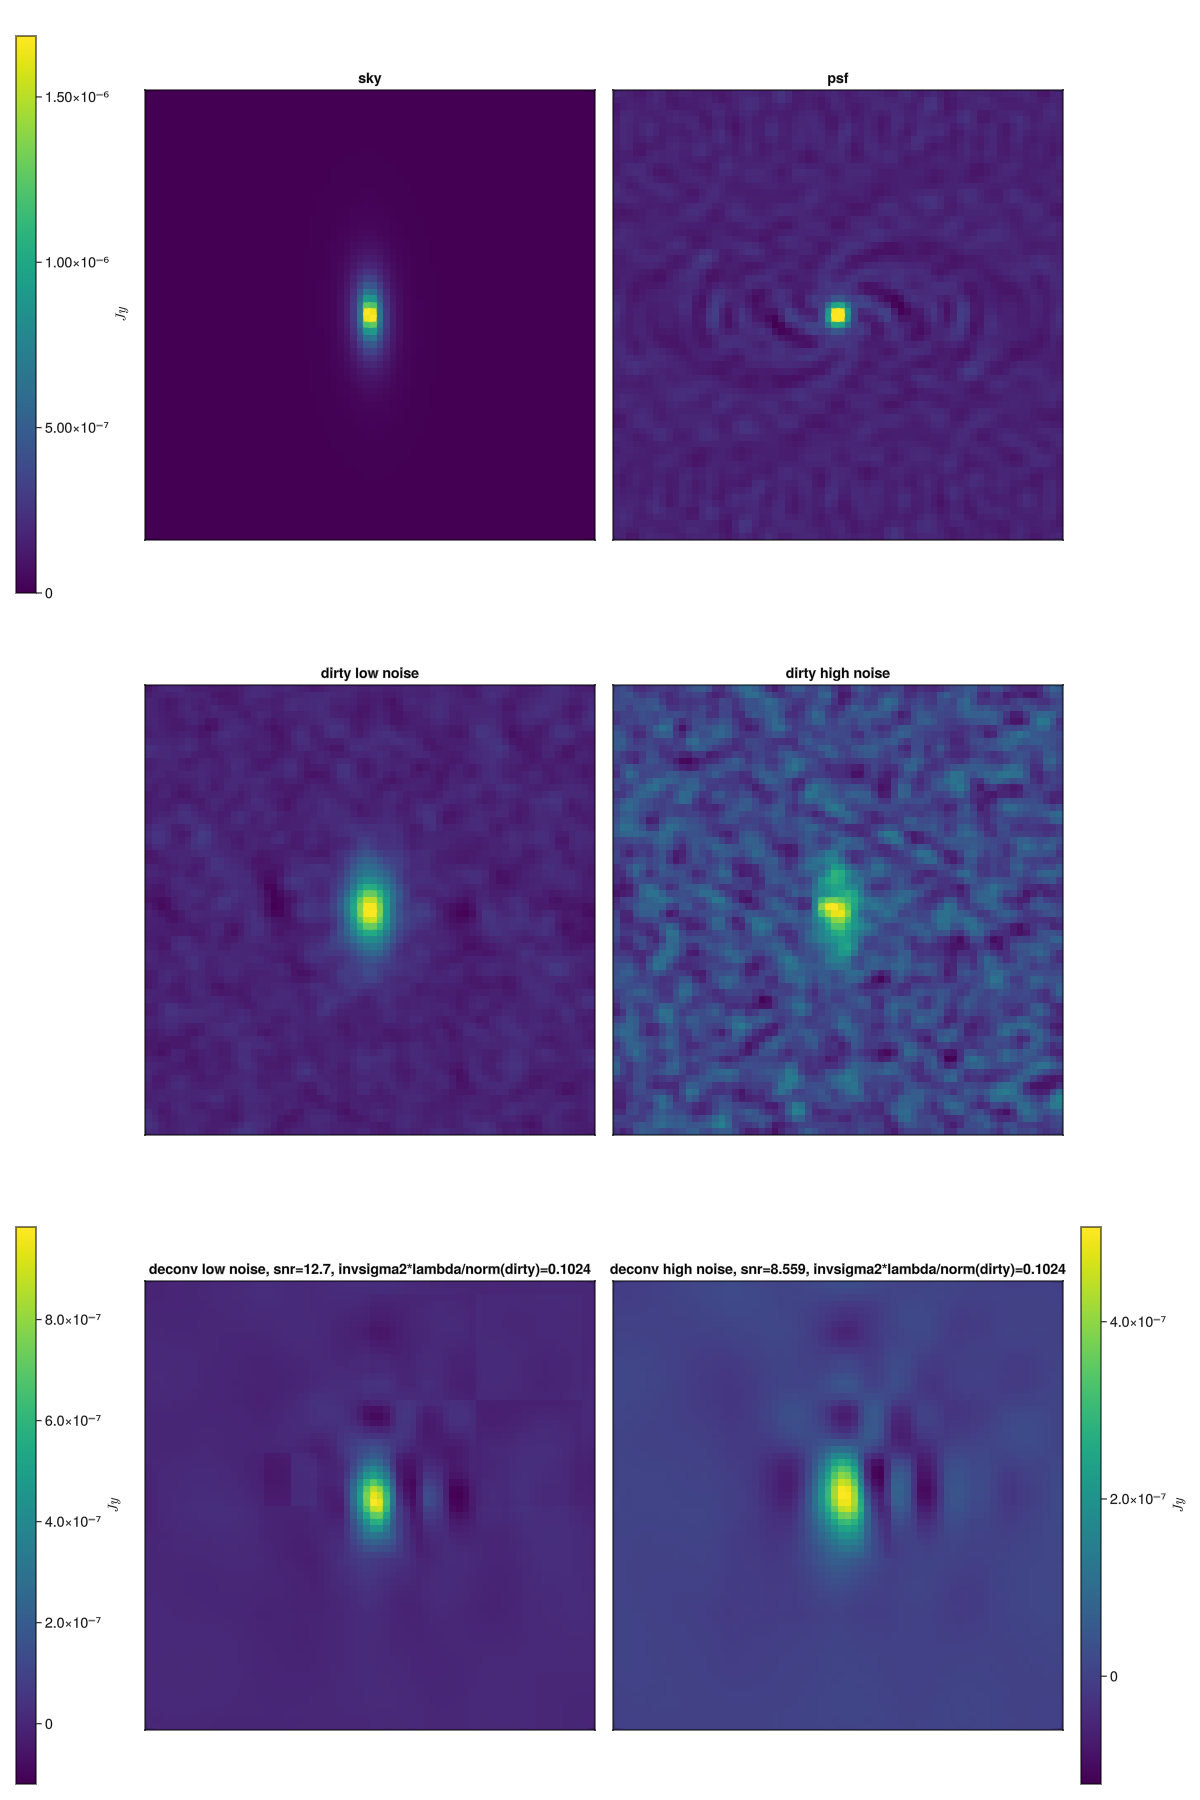

In [22]:
snr_low, ind_low = findmax(snrs_low)
snr_high, ind_high = findmax(snrs_high)

low_lambda = invsigma2 * lambdas[ind_low] * norm(dirty_low)
high_lambda = invsigma2 * lambdas[ind_high] * norm(dirty_high)

deconv_low, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), low_lambda, 50; sky=Float64.(sky))
deconv_high, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), high_lambda, 50; sky=Float64.(sky))
                    
fig = Figure(; size = (1200, 1800))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="psf", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="dirty low noise", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="dirty high noise", aspect=DataAspect())

llow = lambdas[ind_low]
lhigh = lambdas[ind_high]

ax5 = Axis(fig[3, 1], title="deconv low noise, snr=$(round(snr_low, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(llow, sigdigits=4))", aspect=DataAspect())
ax6 = Axis(fig[3, 2], title="deconv high noise, snr=$(round(snr_high, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(lhigh, sigdigits=4))", aspect=DataAspect())

hm = heatmap!(ax1, crop_img(sky, size_mask))
Colorbar(fig[1, 0], hm, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
heatmap!(ax2, crop_img(psf, size_mask))
heatmap!(ax3, crop_img(dirty_low, size_mask))
heatmap!(ax4, crop_img(dirty_high, size_mask))
hm2 = heatmap!(ax5, crop_img(deconv_low, size_mask))
Colorbar(fig[3, 0], hm2, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
hm3 = heatmap!(ax6, crop_img(deconv_high, size_mask))
Colorbar(fig[3, 3], hm3, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
hidedecorations!(ax4)
hidedecorations!(ax5)
hidedecorations!(ax6)
fig

### Now assuming some i.i.d Gaussian noise in the image domain, i.e. $\sigma^2 I$
### The gradient becomes $W^\dagger F^\dagger \Delta^\dagger \Sigma^{-1}(\Delta F W\alpha - F\tilde{\imath})$

In [13]:
using FFTW, LinearAlgebra

lambdas = LinRange(1e-4, 10, 128)

invsigma2 = 1
cov = invsigma2 * Matrix(I, size(psf));

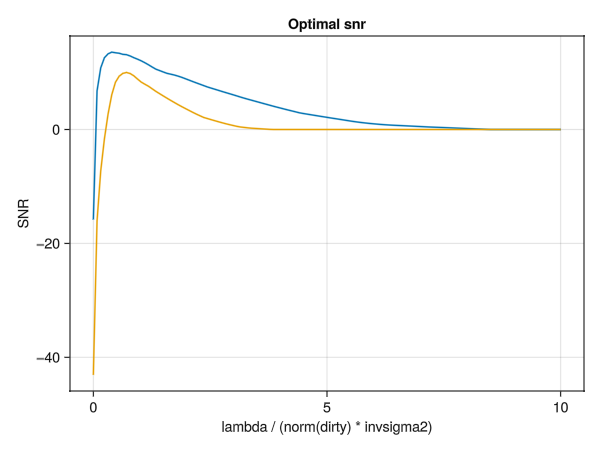

In [176]:
snrs_low = Float64[]
snrs_high = Float64[]
for lambda in lambdas
    deconv, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), invsigma2 * lambda * norm(dirty_low), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_low, snr) 
end
for lambda in lambdas
    deconv, mse = fista_cov(Float64.(psf), Float64.(dirty_high), Float64.(cov), invsigma2 * lambda * norm(dirty_high), 50; sky=Float64.(sky))
    snr = 20 * log(norm(sky) / sqrt(mse[end]))
    push!(snrs_high, snr) 
end

fig = Figure()
ax1 = Axis(fig[1, 1], title  = "Optimal snr", ylabel = "SNR", xlabel="lambda / (norm(dirty) * invsigma2)")
lines!(lambdas, snrs_low)
lines!(lambdas, snrs_high)
#scatter!([α_cov], [snr_cov])
fig

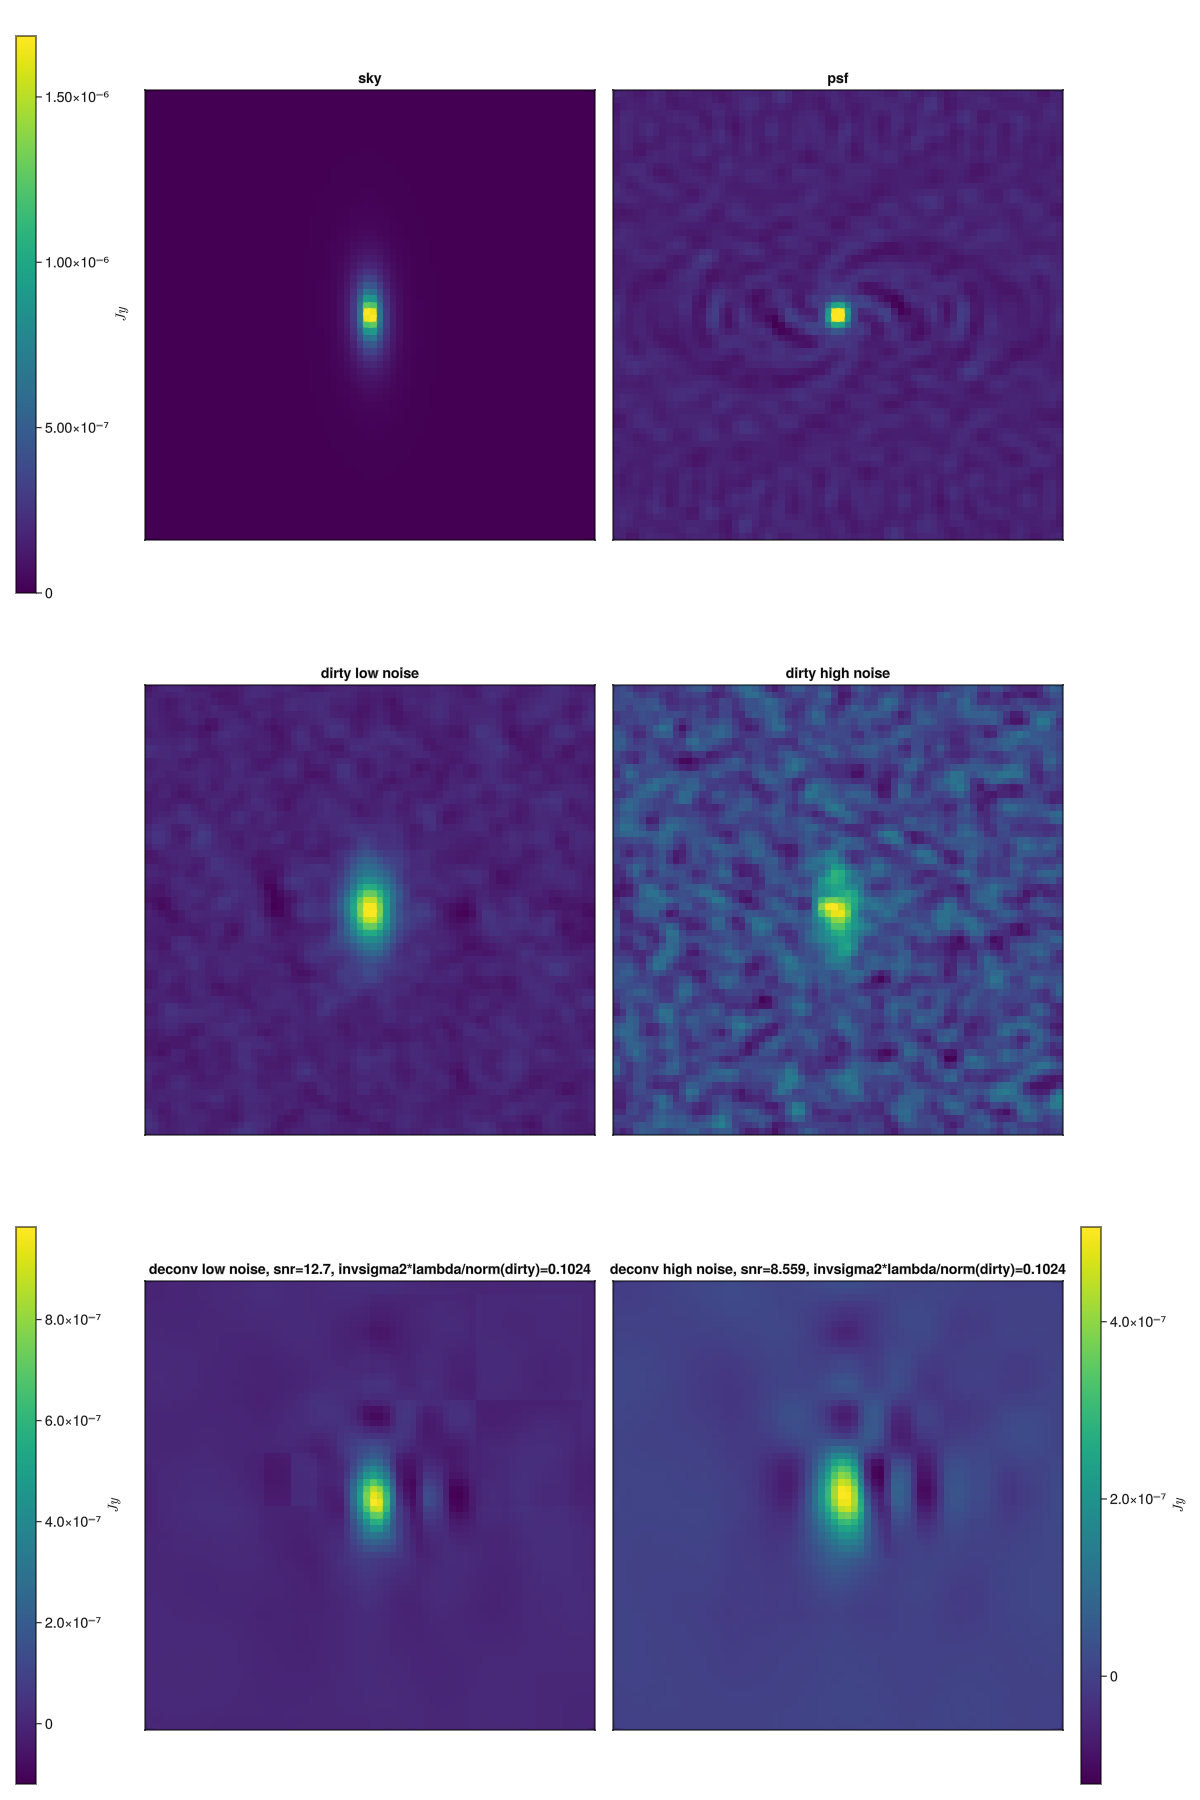

In [37]:
snr_low, ind_low = findmax(snrs_low)
snr_high, ind_high = findmax(snrs_high)

low_lambda = invsigma2 * lambdas[ind_low] * norm(dirty_low)
high_lambda = invsigma2 * lambdas[ind_high] * norm(dirty_high)

deconv_low, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), low_lambda, 50; sky=Float64.(sky))
deconv_high, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), high_lambda, 50; sky=Float64.(sky))

deconv_low_ll, mse = fista_cov(Float64.(psf), Float64.(dirty_low), Float64.(cov), 0.75 * low_lambda, 50; sky=Float64.(sky))
snr_low_ll = 20 * log(norm(sky) / sqrt(mse[end]))
deconv_high_ll, mse = fista_cov(Float64.(psf), Float64.(dirty_high), Float64.(cov), 0.75 * high_lambda, 50; sky=Float64.(sky))
snr_high_ll = 20 * log(norm(sky) / sqrt(mse[end]))
                    
fig = Figure(; size = (1200, 1800))
ax1 = Axis(fig[1, 1], title="sky", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="psf", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="dirty low noise", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="dirty high noise", aspect=DataAspect())

llow = lambdas[ind_low]
lhigh = lambdas[ind_high]

ax5 = Axis(fig[3, 1], title="deconv low noise, snr=$(round(snr_low, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(llow, sigdigits=4))", aspect=DataAspect())
ax6 = Axis(fig[3, 2], title="deconv high noise, snr=$(round(snr_high, sigdigits=4)), invsigma2*lambda/norm(dirty)=$(round(lhigh, sigdigits=4))", aspect=DataAspect())

hm = heatmap!(ax1, crop_img(sky, size_mask))
Colorbar(fig[1, 0], hm, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
heatmap!(ax2, crop_img(psf, size_mask))
heatmap!(ax3, crop_img(dirty_low, size_mask))
heatmap!(ax4, crop_img(dirty_high, size_mask))
hm2 = heatmap!(ax5, crop_img(deconv_low, size_mask))
Colorbar(fig[3, 0], hm2, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)
hm3 = heatmap!(ax6, crop_img(deconv_high, size_mask))
Colorbar(fig[3, 3], hm3, label = L"Jy", width = 20, labelsize = 14, ticklabelsize = 14)

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)
hidedecorations!(ax4)
hidedecorations!(ax5)
hidedecorations!(ax6)
fig

## Test to check for symmetry of the psf

#### Original - provided psf
#### Truncated - dropped first row and column
#### Zeroed - zeroed first row and column
#### Half shifted - psf shifted by -0.5,-0.5 pixels
#### rascil dirac halfshifted - dirty image obtained 

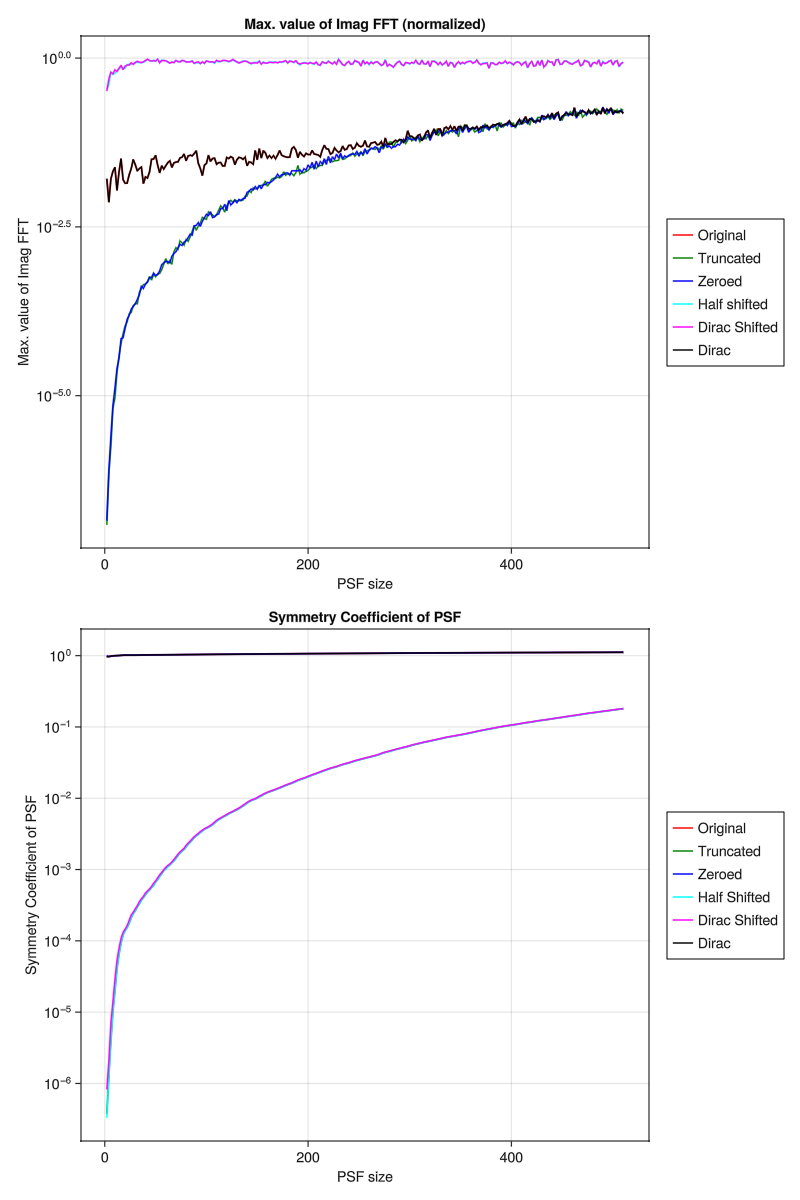

In [12]:
sym_coef(a) = norm(a - reverse(reverse(a, dims=2), dims=1))/norm(a)

psf = read(FITS("psf512.fits")[1])
rascil_diracshifted_dirty = read(FITS("shifted_dirac_dirty.fits")[1])
rascil_dirac_dirty = read(FITS("dirac_dirty.fits")[1])

n = size(psf)[1]
c = Int(n/2)

sub, zeroed, truncated, halfshifted, sub_rascil, dirac = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
subsym, zeroedsym, truncatedsym, halfshiftedsym, subsym_rascil, diracsym = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

for k in 1:Int(n/2 - 1)
    sub_psf = copy(psf[c-k:c+k+1, c-k:c+k+1])
    push!(sub, maximum(abs.(imag.(fft(ifftshift(sub_psf))))) / maximum(abs.(real.(fft(ifftshift(sub_psf))))))
    push!(subsym, sym_coef(sub_psf))
    
    truncated_psf = copy(sub_psf[2:end, 2:end])
    push!(truncated, maximum(abs.(imag.(fft(ifftshift(truncated_psf))))) / maximum(abs.(real.(fft(ifftshift(truncated_psf))))))
    push!(truncatedsym, sym_coef(truncated_psf))
                            
    zeroed_psf = copy(sub_psf)
    zeroed_psf[1,:] .= 0
    zeroed_psf[:,1] .= 0
    push!(zeroed, maximum(abs.(imag.(fft(ifftshift(zeroed_psf))))) / maximum(abs.(real.(fft(ifftshift(zeroed_psf))))))
    push!(zeroedsym, sym_coef(zeroed_psf))
    
    trunc_padded = vcat(zeros(1,(k+1)*2), hcat(zeros((k+1)*2-1,1), truncated_psf))
    halfshifted_psf = shift(trunc_padded, (-0.5, -0.5))
    push!(halfshifted, maximum(abs.(imag.(fft(ifftshift(halfshifted_psf))))) / maximum(abs.(real.(fft(ifftshift(halfshifted_psf))))))
    push!(halfshiftedsym, sym_coef(halfshifted_psf))
            
    rascil_shifted = copy(rascil_diracshifted_dirty[c-k:c+k+1, c-k:c+k+1])
    push!(sub_rascil, maximum(abs.(imag.(fft(ifftshift(rascil_shifted))))) / maximum(abs.(real.(fft(ifftshift(rascil_shifted))))))
    push!(subsym_rascil, sym_coef(rascil_shifted))
                            
    rascil_dirac = copy(rascil_dirac_dirty[c-k:c+k+1, c-k:c+k+1])
    push!(dirac, maximum(abs.(imag.(fft(ifftshift(rascil_dirac))))) / maximum(abs.(real.(fft(ifftshift(rascil_dirac))))))
    push!(diracsym, sym_coef(rascil_dirac))
end
    
fig = Figure(size=(800, 1200))
ax1 = Axis(fig[1, 1], xlabel="PSF size", ylabel="Max. value of Imag FFT", yscale=log10, title="Max. value of Imag FFT (normalized)")
lsub = lines!(2*(1:Int(n/2) - 1), sub, color = :red)
ltrunc = lines!(2*(1:Int(n/2) - 1), truncated, color = :green)
lzeroed = lines!(2*(1:Int(n/2) - 1), zeroed, color = :blue)
lshift = lines!(2*(1:Int(n/2) - 1), halfshifted, color = :cyan)
lrascil = lines!(2*(1:Int(n/2) - 1), sub_rascil, color = :magenta)
ldirac = lines!(2*(1:Int(n/2) - 1), dirac, color = :black)
Legend(fig[1, 2], [lsub, ltrunc, lzeroed, lshift, lrascil, ldirac], ["Original", "Truncated", "Zeroed", "Half shifted", "Dirac Shifted", "Dirac"])

ax2 = Axis(fig[2, 1], xlabel="PSF size", ylabel="Symmetry Coefficient of PSF", yscale=log10, title="Symmetry Coefficient of PSF")
lsub = lines!(2*(1:Int(n/2) - 1), subsym, color = :red)
ltrunc = lines!(2*(1:Int(n/2) - 1), truncatedsym, color = :green)
lzeroed = lines!(2*(1:Int(n/2) - 1), zeroedsym, color = :blue)
lshift = lines!(2*(1:Int(n/2) - 1), halfshiftedsym, color = :cyan)
lrascil = lines!(2*(1:Int(n/2) - 1), subsym_rascil, color = :magenta)
ldirac = lines!(2*(1:Int(n/2) - 1), diracsym, color = :black)
Legend(fig[2, 2], [lsub, ltrunc, lzeroed, lshift, lrascil, ldirac], ["Original", "Truncated", "Zeroed", "Half Shifted", "Dirac Shifted", "Dirac"])

fig

### Imaginary components of fourier transform of psfs and the dirty images obtained from diracs

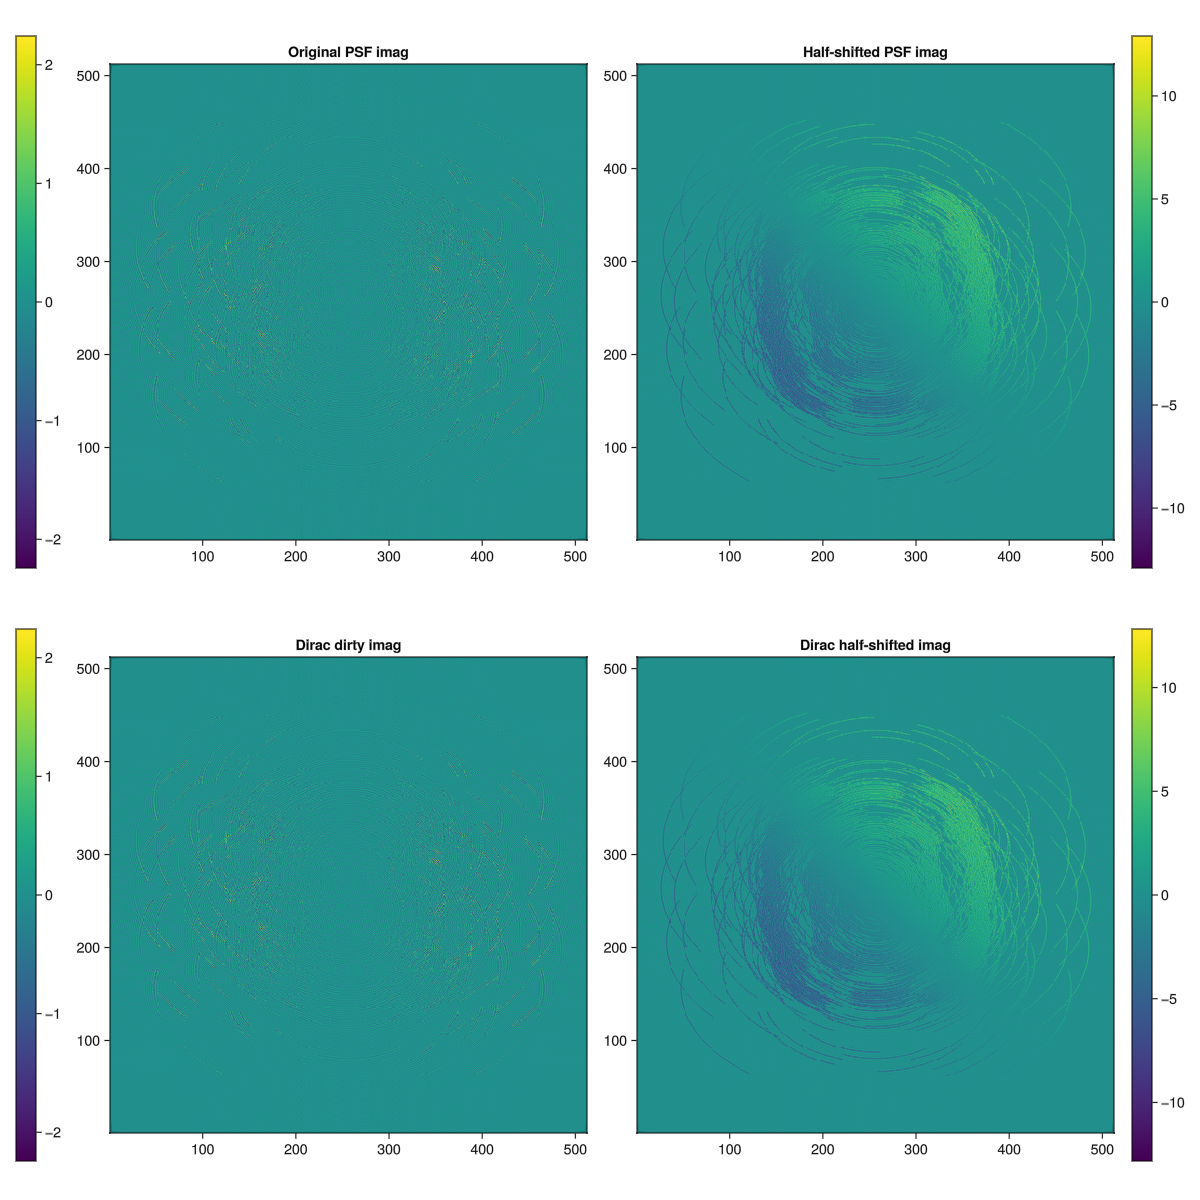

In [14]:
truncated_psf = copy(psf[2:end, 2:end])
trunc_padded = vcat(zeros(1,n), hcat(zeros(n-1,1), truncated_psf))
halfshifted_psf = shift(trunc_padded, (-0.5, -0.5))
psf = copy(psf[1:end, 1:end])

fig = Figure(; size = (1200, 1200))
ax1 = Axis(fig[1, 1], title="Original PSF imag", aspect=DataAspect())
ax2 = Axis(fig[1, 2], title="Half-shifted PSF imag", aspect=DataAspect())
ax3 = Axis(fig[2, 1], title="Dirac dirty imag", aspect=DataAspect())
ax4 = Axis(fig[2, 2], title="Dirac half-shifted imag", aspect=DataAspect())
                        
size_mask = 0
hm1=heatmap!(ax1, imag.(fftshift(fft(ifftshift(psf)))))
Colorbar(fig[1, 0], hm1, width = 20, labelsize = 14, ticklabelsize = 14)
hm2=heatmap!(ax2, imag.(fftshift(fft(ifftshift(halfshifted_psf)))))
Colorbar(fig[1, 3], hm2, width = 20, labelsize = 14, ticklabelsize = 14)
hm3=heatmap!(ax3, imag.(fftshift(fft(ifftshift(rascil_dirac_dirty)))))
Colorbar(fig[2, 0], hm3, width = 20, labelsize = 14, ticklabelsize = 14)
hm4=heatmap!(ax4, imag.(fftshift(fft(ifftshift(rascil_diracshifted_dirty)))))
Colorbar(fig[2, 3], hm4, width = 20, labelsize = 14, ticklabelsize = 14)

fig